<a href="https://colab.research.google.com/github/santossousa/TRANSFER-NCIA-DE-CONHECIMENTO-PARA-DETEC-O-AUTOM-TICA-DE-FAKE-NEWS-COM-APRENDIZAGEM-PROFUNDA/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --version 1.7 --apt-packages libomp5 libopenblas-dev
#!python3 pytorch-xla-env-setup.py --version 1.7 --apt-packages libomp5 libopenblas-dev

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.9 MB/s 
     |████████████████████████████████| 101 kB 12.0 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
     |████████████████████████████████| 6.6 MB 70.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
#import torch_xla
#import torch_xla.debug.metrics as met
#import torch_xla.distributed.data_parallel as dp
#import torch_xla.distributed.parallel_loader as pl
#import torch_xla.utils.utils as xu
#import torch_xla.core.xla_model as xm
#import torch_xla.distributed.xla_multiprocessing as xmp
#import torch_xla.test.test_utils as test_utils
import warnings

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

#from google.colab import drive
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from transformers import AdamW, get_linear_schedule_with_warmup
import re
import string

In [5]:

from transformers import BertTokenizer, BertModel

from collections import defaultdict

In [6]:

labels = {'fake':0,
          'true':1
          }
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

In [7]:
data = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv')


In [8]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
data.head()

,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...


In [10]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X,y):

        self.labels = [labels[label] for label in y]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 500, truncation=True,
                                return_tensors="pt") for text in X]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [11]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer


In [12]:
from collections import defaultdict
from numpy import mean

In [13]:
history = defaultdict(list)

def train(model, train_data, y_train, val_data, y_val, learning_rate, epochs):
    
    train, val = Dataset(train_data, y_train), Dataset(val_data, y_val)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16,shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    criterion = nn.CrossEntropyLoss()
    #optimizer = AdamW(optimizer_parameters,lr=learning_rate)
    #print(list(optimizer_parameters))
    optimizer = Adam(model.parameters(), lr= learning_rate)
    num_train_steps = int(len(train_data)*epochs)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )
    #device = xm.xla_device()
    #model.to(device)
   # model.train()

    
    
    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()
    model.train()


    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device, dtype=torch.long)
                mask = train_input['attention_mask'].to(device, dtype=torch.long)
                input_id = train_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                #xm.optimizer_step(optimizer)
                optimizer.step()
                scheduler.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device, dtype=torch.long)
                    mask = val_input['attention_mask'].to(device, dtype=torch.long)
                    input_id = val_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            history['train_acc'].append((total_acc_train / len(train_data)))
            history['train_loss'].append((total_loss_train / len(train_data)))
            history['val_acc'].append((total_acc_val / len(val_data)))
            history['val_loss'].append((total_loss_val / len(val_data)))

In [14]:
def evaluate(model, test_data,y_test):

    test = Dataset(test_data,y_test)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()
    model.eval()
    total_acc_test = 0
    predictions_labels = []
    true_labels = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              true_labels += test_label.cpu().numpy().flatten().tolist()
              predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels, (total_acc_test / len(test_data))

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
X = data['preprocessed_news']
y = data['label']

In [16]:
from transformers import logging
logging.set_verbosity_error()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = None, random_state=42)


In [18]:
%%time
#3e-6
lrs = [1e-5,2e-5,3e-5,4e-5,5e-5]
i = 0
#device = xm.xla_device()
bertClassifier = BertClassifier()
best_model = None
best_acc = 0

for fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold =  X_train.iloc[valid_idx]
    y_val_fold = y_train.iloc[valid_idx]
    print("Fold {} of {}".format(fold + 1, 5))
    print("Train len: {} Val len: {}".format(len(X_train_fold), len(X_val_fold)))
    EPOCHS = 3 
    print("Learning curve: ",lrs[i])
    LR = 1e-6
    train(bertClassifier, X_train_fold, y_train_fold, X_val_fold, y_val_fold, lrs[i], EPOCHS)
    true_labels, pred_labels, val_acc = evaluate(bertClassifier,X_val_fold, y_val_fold)
    print("acc: ",val_acc)
    if val_acc > best_acc:
        print("The best: ",best_acc)
        best_model = bertClassifier
        torch.save(bertClassifier.state_dict(), 'best_model_state.bin')
        best_acc=val_acc
  
    i+=1

Fold 1 of 5
Train len: 4608 Val len: 1152
Learning curve:  1e-05


100%|██████████| 288/288 [06:58<00:00,  1.45s/it]


Epochs: 1 | Train Loss:  0.028 | Train Accuracy:  0.926 | Val Loss:  0.027 | Val Accuracy:  0.949


100%|██████████| 288/288 [07:15<00:00,  1.51s/it]


Epochs: 2 | Train Loss:  0.026 | Train Accuracy:  0.955 | Val Loss:  0.026 | Val Accuracy:  0.956


100%|██████████| 288/288 [07:15<00:00,  1.51s/it]


Epochs: 3 | Train Loss:  0.024 | Train Accuracy:  0.966 | Val Loss:  0.026 | Val Accuracy:  0.960
Test Accuracy:  0.962
acc:  0.9618055555555556
The best:  0
Fold 2 of 5
Train len: 4608 Val len: 1152
Learning curve:  2e-05


100%|██████████| 288/288 [07:08<00:00,  1.49s/it]


Epochs: 1 | Train Loss:  0.025 | Train Accuracy:  0.967 | Val Loss:  0.023 | Val Accuracy:  0.977


100%|██████████| 288/288 [07:20<00:00,  1.53s/it]


Epochs: 2 | Train Loss:  0.008 | Train Accuracy:  0.974 | Val Loss:  0.014 | Val Accuracy:  0.917


100%|██████████| 288/288 [07:21<00:00,  1.53s/it]


Epochs: 3 | Train Loss:  0.004 | Train Accuracy:  0.983 | Val Loss:  0.002 | Val Accuracy:  0.986
Test Accuracy:  0.986
acc:  0.9861111111111112
The best:  0.9618055555555556
Fold 3 of 5
Train len: 4608 Val len: 1152
Learning curve:  3e-05


100%|██████████| 288/288 [07:14<00:00,  1.51s/it]


Epochs: 1 | Train Loss:  0.003 | Train Accuracy:  0.986 | Val Loss:  0.001 | Val Accuracy:  0.995


100%|██████████| 288/288 [07:21<00:00,  1.53s/it]


Epochs: 2 | Train Loss:  0.002 | Train Accuracy:  0.991 | Val Loss:  0.002 | Val Accuracy:  0.992


100%|██████████| 288/288 [07:21<00:00,  1.53s/it]


Epochs: 3 | Train Loss:  0.001 | Train Accuracy:  0.996 | Val Loss:  0.001 | Val Accuracy:  0.997
Test Accuracy:  0.997
acc:  0.9965277777777778
The best:  0.9861111111111112
Fold 4 of 5
Train len: 4608 Val len: 1152
Learning curve:  4e-05


100%|██████████| 288/288 [07:14<00:00,  1.51s/it]


Epochs: 1 | Train Loss:  0.001 | Train Accuracy:  0.993 | Val Loss:  0.004 | Val Accuracy:  0.965


100%|██████████| 288/288 [07:20<00:00,  1.53s/it]


Epochs: 2 | Train Loss:  0.001 | Train Accuracy:  0.995 | Val Loss:  0.001 | Val Accuracy:  0.997


100%|██████████| 288/288 [07:20<00:00,  1.53s/it]


Epochs: 3 | Train Loss:  0.001 | Train Accuracy:  0.996 | Val Loss:  0.000 | Val Accuracy:  0.997
Test Accuracy:  0.997
acc:  0.9973958333333334
The best:  0.9965277777777778
Fold 5 of 5
Train len: 4608 Val len: 1152
Learning curve:  5e-05


100%|██████████| 288/288 [07:14<00:00,  1.51s/it]


Epochs: 1 | Train Loss:  0.002 | Train Accuracy:  0.992 | Val Loss:  0.004 | Val Accuracy:  0.972


100%|██████████| 288/288 [07:20<00:00,  1.53s/it]


Epochs: 2 | Train Loss:  0.001 | Train Accuracy:  0.995 | Val Loss:  0.001 | Val Accuracy:  0.994


100%|██████████| 288/288 [07:20<00:00,  1.53s/it]


Epochs: 3 | Train Loss:  0.000 | Train Accuracy:  1.000 | Val Loss:  0.001 | Val Accuracy:  0.997
Test Accuracy:  0.998
acc:  0.9982638888888888
The best:  0.9973958333333334
CPU times: user 2h 8min 47s, sys: 24.3 s, total: 2h 9min 11s
Wall time: 2h 10min


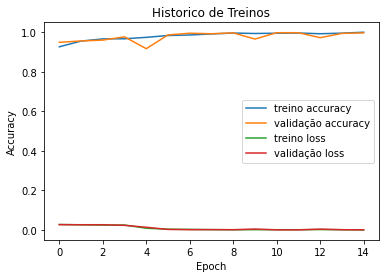

In [19]:
plt.plot(history['train_acc'], label='treino accuracy')
plt.plot(history['val_acc'], label='validação accuracy') 
plt.plot(history['train_loss'], label='treino loss')
plt.plot(history['val_loss'], label='validação loss') 
plt.title('Historico de Treinos')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [20]:
true_labels, pred_labels, acc = evaluate(best_model, X_test,y_test)

Test Accuracy:  0.976


In [ ]:
def show_confusion_matrix(confusion_matrix, title='Confusion matrix'):
    plt.title(title)
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
from sklearn.metrics import confusion_matrix, classification_report


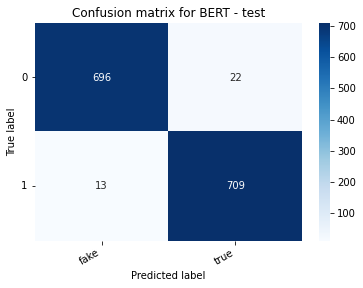

In [26]:
cm = confusion_matrix(true_labels, pred_labels)
df_cm = pd.DataFrame(cm, index=np.unique(true_labels), columns=np.unique(y_test))
show_confusion_matrix(df_cm, title='Confusion matrix for BERT - test')

In [23]:
from sklearn.metrics import confusion_matrix, classification_report


In [27]:

class_report=classification_report(true_labels, pred_labels)
print(class_report)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       718
           1       0.97      0.98      0.98       722

    accuracy                           0.98      1440
   macro avg       0.98      0.98      0.98      1440
weighted avg       0.98      0.98      0.98      1440

